In [6]:

import sys
import os

repo_root = os.path.abspath(os.path.join(os.path.dirname(os.getcwd())))
sys.path.append(repo_root)

print(repo_root)

/home/jayeun/core_classes/proj_energy_volatility


In [27]:
import matplotlib.pyplot as plt
import math 
import numpy as np
import pandas as pd
from pandas_datareader import data as pdr
from statsmodels.tsa.stattools import adfuller, coint
from arch import arch_model

In [8]:
data = ['CPIAUCSL', 'GDPC1', 'CNP16OV', 'FEDFUNDS', 'LRUN64MAUSM156S', 'LRUN64FEUSM156S']

In [9]:

df = pdr.DataReader(
    data,
    "fred",
    start="1980-01-01",
    end="2025-07-01"
).astype(float).reset_index()

In [12]:
df['INF'] = 400 * np.log(df['CPIAUCSL']/ df['CPIAUCSL'].shift(-1))
df['INF_demeaned'] = df['INF'] - df['INF'].mean()
df['INF_r'] = df['INF'].diff()

Text(0, 0.5, '$\\Delta$ INF')

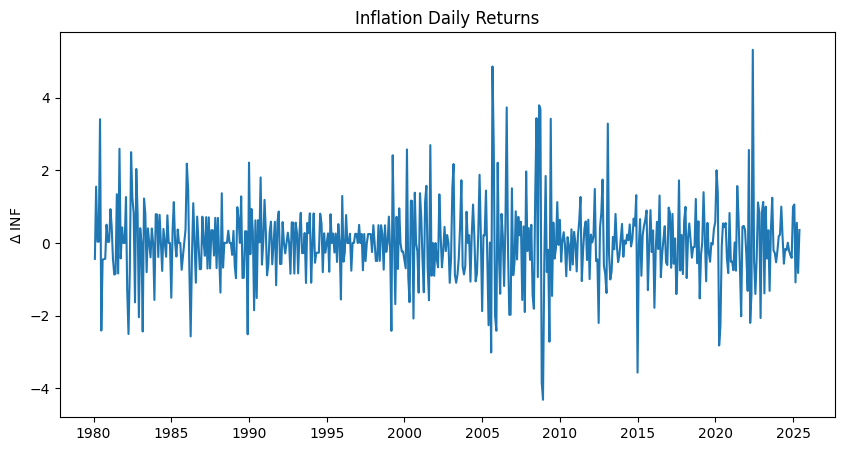

In [20]:
plt.figure(figsize=(10,5))
plt.plot(df['DATE'], df['INF_r'])

plt.title('Inflation Daily Returns')
plt.ylabel('$\Delta$ INF')

In [23]:
adfuller(df['INF_r'].dropna())


(np.float64(-10.44093707157073),
 np.float64(1.5226799422872562e-18),
 13,
 531,
 {'1%': np.float64(-3.4427251295084678),
  '5%': np.float64(-2.8669984098683736),
  '10%': np.float64(-2.5696771375119254)},
 np.float64(1415.8292701630317))

In [39]:
def realized_vol(time_series, window: int = 21, annualize: bool = True) -> pd.DataFrame:
    """Compute rolling standard deviation of daily returns (realized volatility)."""
    
    volatility = time_series.rolling(window).std()
    
    if annualize:
        volatility *= np.sqrt(256)
    
    return volatility

In [40]:
df['vol'] = realized_vol(df['INF_r'])

In [41]:
filtered = df[['DATE', 'INF_r','FEDFUNDS', 'vol']].dropna()

In [56]:
model = arch_model(filtered['INF_r'], mean='Constant', vol='Garch', p=1, q=1, x=filtered['FEDFUNDS'],  dist='normal')
results = model.fit()
print(results.summary())

Iteration:      1,   Func. Count:      6,   Neg. LLF: 16300.097325822568
Iteration:      2,   Func. Count:     13,   Neg. LLF: 234438.12585690382
Iteration:      3,   Func. Count:     19,   Neg. LLF: 775.5486863582487
Iteration:      4,   Func. Count:     26,   Neg. LLF: 845.0018154029556
Iteration:      5,   Func. Count:     33,   Neg. LLF: 792.8328699402548
Iteration:      6,   Func. Count:     39,   Neg. LLF: 728.5228733328158
Iteration:      7,   Func. Count:     45,   Neg. LLF: 728.4297300774449
Iteration:      8,   Func. Count:     50,   Neg. LLF: 728.4290063148022
Iteration:      9,   Func. Count:     55,   Neg. LLF: 728.4289980599365
Iteration:     10,   Func. Count:     59,   Neg. LLF: 728.4289980599651
Optimization terminated successfully    (Exit mode 0)
            Current function value: 728.4289980599365
            Iterations: 10
            Function evaluations: 59
            Gradient evaluations: 10
                     Constant Mean - GARCH Model Results             

In [57]:
results.conditional_volatility

21     1.186457
22     1.015255
23     0.901392
24     0.790342
25     0.716391
         ...   
541    0.843005
542    0.955390
543    1.019080
544    0.925226
545    0.924417
Name: cond_vol, Length: 525, dtype: float64

In [58]:
len(df['DATE'])

547

ValueError: x and y must have same first dimension, but have shapes (545,) and (525,)

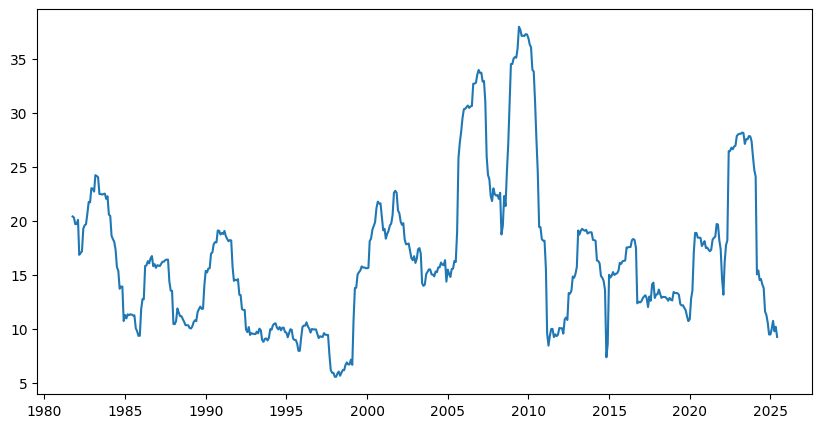

In [59]:
plt.figure(figsize=(10,5))
plt.plot(df['DATE'], df['vol'])
plt.plot(df['DATE'][2:], results.conditional_volatility)

plt.title('Realized Volatility of Inflation')
plt.ylabel('Vol')

In [60]:
forecast = results.forecast(horizon=5).mean

In [61]:
print(forecast)

          h.1       h.2       h.3       h.4       h.5
545 -0.005413 -0.005413 -0.005413 -0.005413 -0.005413


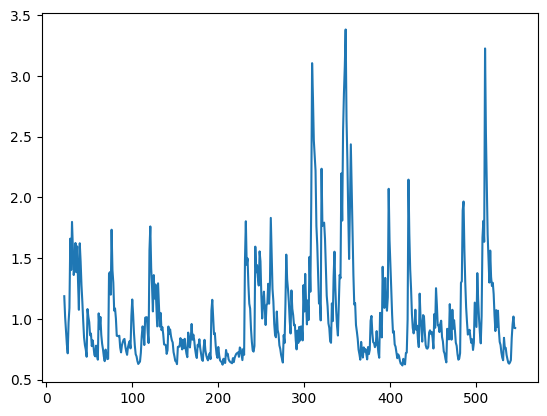

In [67]:
plt.plot(results.conditional_volatility)